In [1]:
import torch
from skripsi_program.basis import FourierBasis
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ndims = 4
a = torch.arange(12).reshape((-1,ndims))
f = [6,7,8,9]


In [3]:
basis = FourierBasis.fn(a,f)

In [4]:
def fn1(
    x: torch.Tensor,
    modes: int | list[int],
    constant=2j * torch.pi,
    transpose: bool = False,
) -> torch.Tensor:
    if isinstance(modes, int):
        modes = [
            modes,
        ]
    assert (
        len(x.shape) > 1
    ), "x must have at least 2 dimensions, the format needs to be row of points, the first dimension of the tensor being each row and the second being dimensions of the points"
    assert (
        x.shape[0] > 0
    ), f"x has shape {x.shape}, make sure the first dimension isn't empty ie. has at least one row of samples"
    assert (
        x.shape[1] == len(modes)
    ), f"x has dimensions {x.shape[1]} and modes has dimensions {len(modes)}, both need to have the same dimensions (modes specify how many modes in each dimension of the fourier series)"
    ndims = x.shape[1]

    # Compute the Fourier basis functions
    # one time for each dimension

    dim = 0
    num_modes = modes[dim]
    dim_basis_shape = [1 for i in range(ndims + 1)]
    dim_basis_shape[0] = x.shape[0]
    dim_basis_shape[dim + 1] = num_modes
    kx = torch.zeros((x.shape[0], modes[0])).reshape(dim_basis_shape)

    for dim, num_modes in enumerate(modes):
        # for dim, num_modes in list(enumerate(modes))[::-1]:
        k = FourierBasis.waveNumber(num_modes).T
        dim_basis_shape = [1 for i in range(ndims + 1)]
        dim_basis_shape[0] = x.shape[0]
        dim_basis_shape[dim + 1] = num_modes
        dim_kx = k * x[:, dim : dim + 1]
        if transpose:
            dim_kx = dim_kx.T
        dim_kx = dim_kx.reshape(dim_basis_shape)

        kx = kx + dim_kx

    basis = torch.exp(constant * kx)

    return basis  # TODO: add multidimensional support

In [5]:
def _raw_fn(
    x: torch.Tensor,
    modes: int,
    transpose: bool,
    constant=2j * torch.pi,
):
    k = FourierBasis.waveNumber(modes).T
    e = torch.exp(constant * k * x)
    if transpose:
        e = e.T

    return e


def _ndim_fn(
    x: torch.Tensor,
    modes: list[int],
    dim: int,
    transpose: bool,
    constant=2j * torch.pi,
):
    # flatten so that each extra dimension is treated as a separate "sample"
    # move dimension to transform to the end so that it can stay intact after f is flatened
    # coeff_transposed = modes.transpose(dim, -1)
    # flatten so that the last dimension is intact
    # coeff_flatened = coeff_transposed.flatten(0, -2)
    ndims = len(modes)

    X_flattened = _raw_fn(
        x[:, dim : dim + 1], modes[dim], constant=constant, transpose=transpose
    )
    X_shape = [1 for i in range(ndims + 1)]
    X_shape[0] = X_flattened.shape[0]
    X_shape[dim + 1] = X_flattened.shape[1]
    X_reshaped = X_flattened.reshape(X_shape)

    tile_shape = [1 for i in range(ndims + 1)]
    for cdim, mode in enumerate(modes, 1):
        if cdim is not dim + 1:
            tile_shape[cdim] = mode
    # print(X_reshaped.shape)
    X_tiled = X_reshaped.tile(tile_shape)
    # unflatten so that the correct shape is returned
    # X =
    # X_transposed = X_flattened.reshape(coeff_transposed.shape)
    # X = X_transposed.transpose(-1, dim)

    return X_tiled


def fn(
    x: torch.Tensor,
    modes: int | list[int],
    constant=2j * torch.pi,
    transpose: bool = False,
):
    """
    transform

    Function to calculate the
    discrete Fourier Transform
    of a real-valued signal f

    Arguments:
        f {torch.Tensor} -- m discretized real valued functions

    Returns:
        torch.Tensor -- m complex valued coefficients of f
    """
    if isinstance(modes, int):
        modes = [modes]
    ndims = len(modes)
    assert (
        ndims == x.shape[1]
    ), f"modes with ndims {ndims} need have the same dimensions as each row in x with shape {x.shape}"
    if ndims == 1:
        X = _raw_fn(x, modes[0], constant=constant, transpose=transpose)
    elif ndims > 1:
        # perform 1d transform over every dimension
        X = _ndim_fn(x, modes, dim=0, constant=constant, transpose=transpose)
        for cdim in range(1, ndims):
            X = X * _ndim_fn(x, modes, dim=cdim, constant=constant, transpose=transpose)

    return X


In [30]:
sr = 0.06
x = torch.arange(-2, 2, sr)
y = torch.arange(-1, 1, sr)
xx, yy = torch.meshgrid([x, y], indexing="xy")

# function 1
freq = 2.7
f1 = 3 * torch.sin(2 * torch.pi * freq * (yy + 0.4 * xx))
# freq = 4
# f1 += torch.sin(2 * torch.pi * freq * yy)
# freq = 7
# f1 += 0.5 * torch.sin(2 * torch.pi * freq * xx*yy)

# function 2
freq = 1.0
f2 = 2 * torch.sin(2 * torch.pi * freq * xx)
# freq = 5
# f2 += torch.sin(2 * torch.pi * freq * yy)
# freq = 10
# f2 += 0.3 * torch.sin(2 * torch.pi * freq * xx*yy)

# f = f1.unsqueeze(0)
f = torch.stack((f1, f2))
f = f * (1 + 0j)  # cast to complex

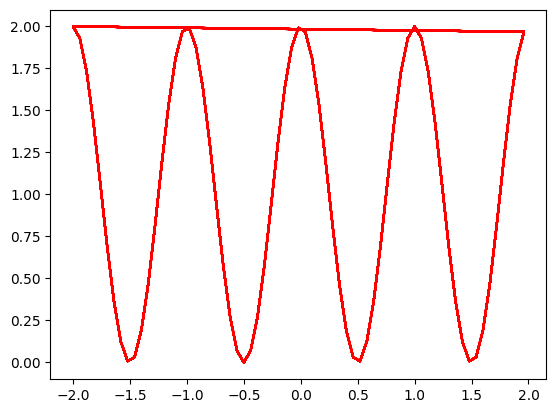

In [36]:
tmp = xx.flatten().reshape((-1, 1))
basis_a = fn1(tmp, 2).sum(1)
plt.plot(tmp.flatten(), basis_a.real, color="r", linestyle="dashed")
plt.show()

In [31]:
f_shape = list(f.shape[1:])
f_shape

[34, 67]

In [32]:
f_coeffs = FourierBasis.transform(f)
f_torch_coeffs: torch.Tensor = torch.fft.fft2(f)
torch.norm(f_coeffs - f_torch_coeffs, 2)

tensor(0.0182)

In [33]:
points = torch.vstack((xx.flatten(),yy.flatten())).T
points.shape

torch.Size([2278, 2])

In [34]:
basis = fn1(points, f_shape, -2j * torch.pi, False)
f_cont_coeff = (f[0].flatten() * basis.transpose(0, -1)).sum(2).transpose(-1, 0)
basis.shape, f_cont_coeff.shape

(torch.Size([2278, 34, 67]), torch.Size([34, 67]))

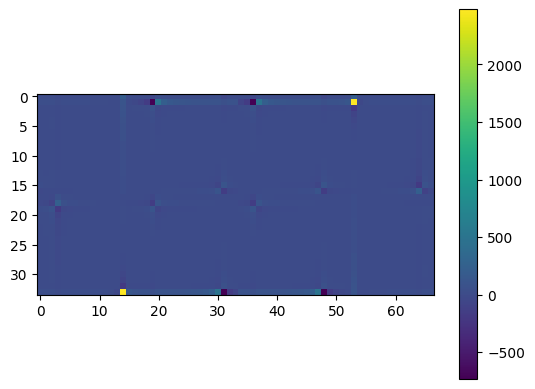

In [35]:
plt.imshow(f_cont_coeff.real)
plt.colorbar()
plt.show()


In [37]:
basis_shape = f_shape
basis = fn1(points, basis_shape)
basis.shape

torch.Size([2278, 34, 67])

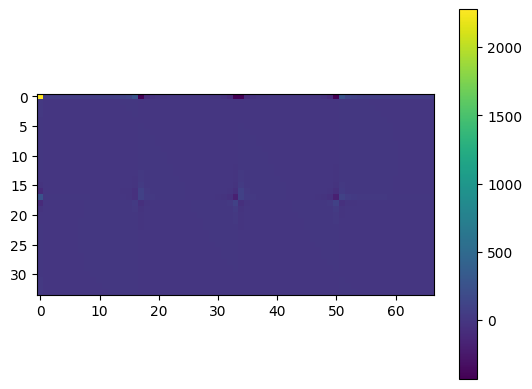

In [38]:
# basis_sum_shape = (-1, 1)
basis_sum_shape = f_shape
basis_sum = torch.sum(
    basis,
    dim=(0),
).reshape(basis_sum_shape)
plt.imshow(basis_sum.real)
plt.colorbar()
plt.show()


In [39]:
f_cont_pred = 1/np.prod(f_coeffs.shape[1:])* torch.sum(
    f_cont_coeff.flatten() * basis.transpose(0,-1),
    dim=(2),
).transpose(-1,0)
f_pred = 1/np.prod(f_coeffs.shape[1:])* torch.sum(
    f_coeffs[0].flatten() * basis.transpose(0,-1),
    dim=(2),
).transpose(-1,0)
f_torch_pred = torch.sum(
    f_torch_coeffs[0].flatten() * basis.transpose(0,-1),
    dim=(2),
).transpose(-1,0)


In [40]:
f_pred.shape

torch.Size([34, 67])

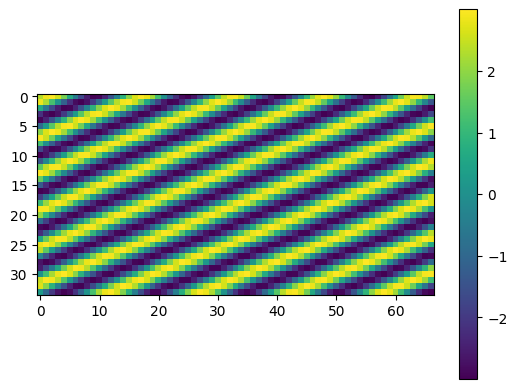

In [41]:
plt.imshow(f[0].real)
plt.colorbar()
plt.show()

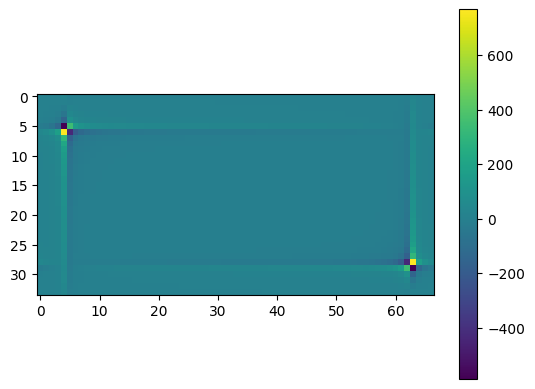

In [42]:
plt.imshow(f_coeffs[0].real)
plt.colorbar()
plt.show()

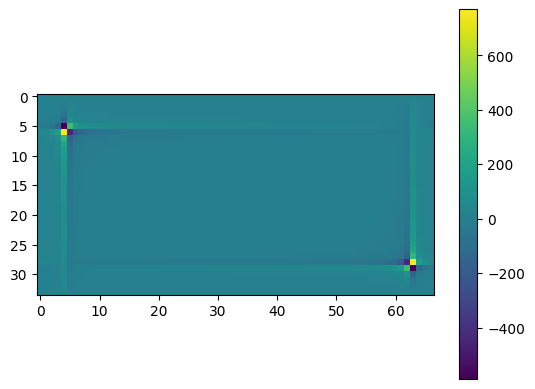

In [43]:
plt.imshow(f_torch_coeffs[0].real)
plt.colorbar()
plt.show()

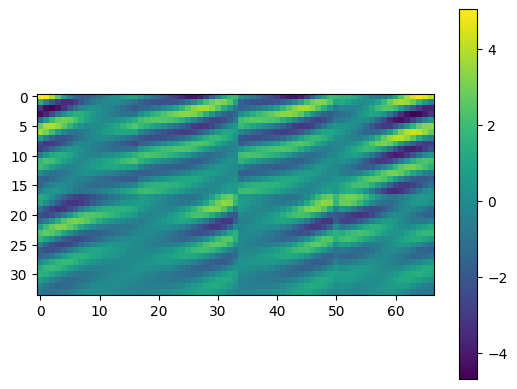

In [44]:
plt.imshow(f_cont_pred.real)
plt.colorbar()
plt.show()

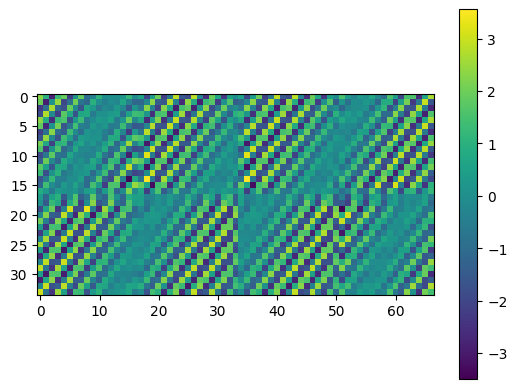

In [45]:
plt.imshow(f_pred.real)
plt.colorbar()
plt.show()

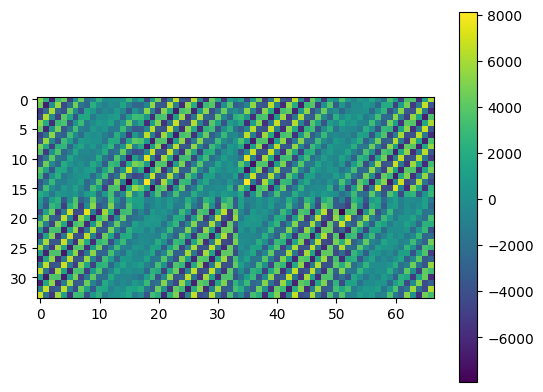

In [46]:
plt.imshow(f_torch_pred.real)
plt.colorbar()
plt.show()

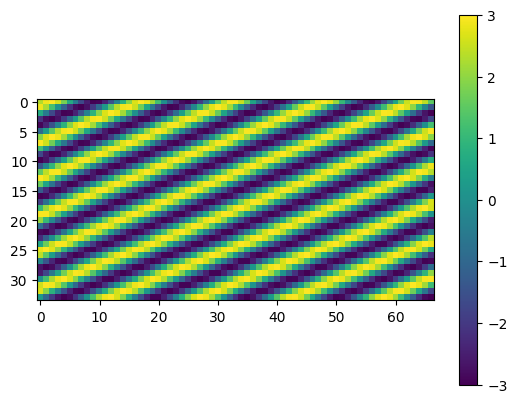

In [47]:
ft = f_coeffs[0]
# ft = torch.fft.fftshift(f_coeffs[0])
# ft = torch.fft.ifftshift(f_torch_coeffs[0])
tmp = torch.fft.ifft2(ft)
plt.imshow(tmp.real)
plt.colorbar()
plt.show()

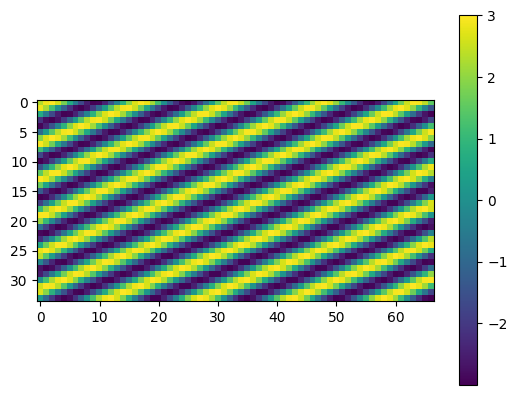

In [48]:
f_inv = FourierBasis.inv_transform(f_coeffs) / torch.tensor(f_coeffs.shape[1:]).prod()
f_inv.shape
plt.imshow(f_inv[0].real)
plt.colorbar()
plt.show()

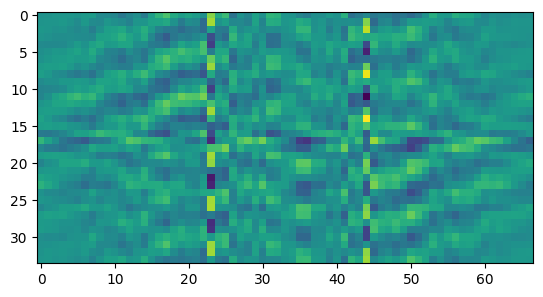

In [49]:
plt.imshow((f_inv - tmp)[0].imag)
plt.show()


In [50]:
dim = 1
modes = list(f_coeffs.shape[1:])

In [51]:
axes = []
for mode in modes:
    axes.append(torch.arange(mode) / mode)

axes_tiled = torch.meshgrid(axes, indexing="xy")
axes_tiled = [axis.flatten().unsqueeze(-1) for axis in axes_tiled]
points = torch.concat(axes_tiled, 1)


In [52]:
basis = fn(points, modes)
basis1 = fn1(points, modes)
torch.norm(basis - basis1, 2)


tensor(0.0097)

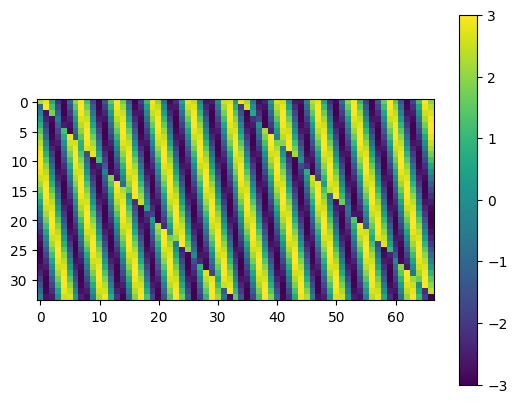

In [53]:
f_reconstruction = (f_coeffs[0] * basis).sum((1,2)).reshape(f_shape) / torch.Tensor(modes).prod()
plt.imshow(f_reconstruction.real)
plt.colorbar()
plt.show()